## Read data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('transactions_n100000.csv')

In [3]:
data.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x7901ee,2019-01-16 18:33:00,7,shake,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,burger,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,fries,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salad,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,fries,1,41.884490,-87.627059


## Data preprocessing

In [4]:
# deleting duplicates
df = data.drop_duplicates(subset="ticket_id")
df.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x7901ee,2019-01-16 18:33:00,7,shake,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salad,1,41.884490,-87.627059
5,0x6d6979,2019-03-18 00:27:00,6,burger,2,41.784576,-87.607565
7,0x78dd1e,2019-09-22 00:10:00,2,shake,2,42.049306,-87.677606
10,0x4df8ab,2019-01-17 11:35:00,8,salad,3,41.894202,-87.620965


In [5]:
# create a pivot table for items
items = pd.pivot_table(data, index='ticket_id', columns='item_name', values='item_count').fillna(0)
df = df.merge(items, on=['ticket_id','ticket_id'])

In [6]:
df.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long,burger,fries,salad,shake
0,0x7901ee,2019-01-16 18:33:00,7,shake,2,41.794132,-88.010140,2.0,2.0,0.0,2.0
1,0x12b47f,2019-09-04 12:36:00,3,salad,1,41.884490,-87.627059,0.0,1.0,1.0,0.0
2,0x6d6979,2019-03-18 00:27:00,6,burger,2,41.784576,-87.607565,2.0,2.0,0.0,0.0
3,0x78dd1e,2019-09-22 00:10:00,2,shake,2,42.049306,-87.677606,2.0,2.0,0.0,2.0
4,0x4df8ab,2019-01-17 11:35:00,8,salad,3,41.894202,-87.620965,0.0,3.0,3.0,0.0


In [7]:
# converting order_timestamp to 'datetime' type
from datetime import datetime
df['date'] = df['order_timestamp'].apply(lambda row: datetime.strptime(str(row), '%Y-%m-%d %H:%M:%S'))

In [8]:
df = df.drop(columns = ['order_timestamp','item_name','item_count'])
df.head()

,ticket_id,location,lat,long,burger,fries,salad,shake,date
0,0x7901ee,7,41.794132,-88.010140,2.0,2.0,0.0,2.0,2019-01-16 18:33:00
1,0x12b47f,3,41.884490,-87.627059,0.0,1.0,1.0,0.0,2019-09-04 12:36:00
2,0x6d6979,6,41.784576,-87.607565,2.0,2.0,0.0,0.0,2019-03-18 00:27:00
3,0x78dd1e,2,42.049306,-87.677606,2.0,2.0,0.0,2.0,2019-09-22 00:10:00
4,0x4df8ab,8,41.894202,-87.620965,0.0,3.0,3.0,0.0,2019-01-17 11:35:00


In [9]:
import calendar
df['weekday'] =  [calendar.day_name[x.weekday()] for x in df['date']]
df['hour'] = df['date'].dt.hour

In [10]:
def time_of_day(row):
    if 7 < row['hour'] < 12:
        return 'Morning'
    elif 12 <= row['hour'] < 18:
        return  'Afternoon'
    elif 18 <= row['hour'] <= 20:
        return 'Dinner'
    elif 20 < row['hour'] <= 23:
        return 'Late-night'
    elif 0 <= row['hour'] <= 6:
        return 'Late-night'

df['time_of_day'] =  df.apply(lambda row: time_of_day(row), axis=1)

In [11]:
df['time_of_day'].value_counts()

Afternoon     34472
Late-night    34210
Dinner        23190
Morning        8128
Name: time_of_day, dtype: int64

In [12]:
df = df.drop(columns = ['date','hour','lat','long'])
df.head()

,ticket_id,location,burger,fries,salad,shake,weekday,time_of_day
0,0x7901ee,7,2.0,2.0,0.0,2.0,Wednesday,Dinner
1,0x12b47f,3,0.0,1.0,1.0,0.0,Wednesday,Afternoon
2,0x6d6979,6,2.0,2.0,0.0,0.0,Monday,Late-night
3,0x78dd1e,2,2.0,2.0,0.0,2.0,Sunday,Late-night
4,0x4df8ab,8,0.0,3.0,3.0,0.0,Thursday,Morning


In [13]:
df['location'] = df['location'].astype('category')
cat = ['location', 'weekday', 'time_of_day']
num = ['burger','fries','salad','shake']
X_cat = df[cat] 

# Creating dummy variable dataframe from categorical variables.
data_X = pd.get_dummies(X_cat)
data_X = df[num].join(data_X)
data_X = data_X.set_index(df['ticket_id'])

In [14]:
data_X.head()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,...,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,time_of_day_Afternoon,time_of_day_Dinner,time_of_day_Late-night,time_of_day_Morning
ticket_id,,,,,,,,,,,,,,,,,,,,,
0x7901ee,2.0,2.0,0.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
0x12b47f,0.0,1.0,1.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
0x6d6979,2.0,2.0,0.0,0.0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
0x78dd1e,2.0,2.0,0.0,2.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
0x4df8ab,0.0,3.0,3.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Split the data (train-test) & Scaling

In [16]:
# split the data
from sklearn import model_selection
train,test = model_selection.train_test_split(data_X, test_size=0.3, random_state = 0)

In [17]:
# scaling
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train_scaled = minmax.fit_transform(train)
test_scaled = minmax.fit_transform(test)

In [18]:
train_scaled = pd.DataFrame(train_scaled, columns = train.columns,index= train.index)
test_scaled = pd.DataFrame(test_scaled,columns = test.columns,index= test.index)

## Kproto Clustering

In [19]:
import numpy as np
from kmodes.kprototypes import KPrototypes
kproto = KPrototypes(n_clusters=3, init='Cao')
clusters = kproto.fit_predict(train_scaled, categorical=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

In [20]:
kproto.cost_

34968.14908630638

In [21]:
clusters_t = kproto.predict(test_scaled, categorical=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

## Validation

In [22]:
train_with_id = train.copy()
train_with_id['cluster_id'] = clusters
train_with_id.cluster_id.value_counts() / len(train)

1    0.355114
2    0.340529
0    0.304357
Name: cluster_id, dtype: float64

In [23]:
test_with_id = test.copy()
test_with_id['cluster_id'] = clusters_t
test_with_id.cluster_id.value_counts() / len(test)

1    0.351233
2    0.339867
0    0.308900
Name: cluster_id, dtype: float64

## Interpretation of the clusters 

In [24]:
train_with_id.groupby('cluster_id').mean()[['weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday']]

,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
cluster_id,,,,,,,
0,0.144849,0.146491,0.142877,0.139779,0.140437,0.144192,0.141375
1,0.138708,0.144058,0.145225,0.143897,0.141403,0.145386,0.141323
2,0.141587,0.142006,0.145278,0.139699,0.140370,0.147712,0.143349


In [25]:
train_with_id.groupby('cluster_id').mean()[['time_of_day_Afternoon',
       'time_of_day_Dinner', 'time_of_day_Late-night', 'time_of_day_Morning']]

,time_of_day_Afternoon,time_of_day_Dinner,time_of_day_Late-night,time_of_day_Morning
cluster_id,,,,
0,0.278902,0.629571,0.090918,0.000610
1,0.000000,0.094819,0.883860,0.021321
2,0.762218,0.014851,0.005328,0.217603


In [26]:
test_with_id.groupby('cluster_id').mean()[['burger','fries','salad','shake','location_1','location_2','location_3',
                                           'location_4','location_5','location_6','location_7','location_8','location_9']]

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9
cluster_id,,,,,,,,,,,,,
0,3.892414,4.068739,0.176325,3.403906,0.031402,0.060537,0.031941,0.250782,0.032049,0.059350,0.247329,0.038632,0.247977
1,1.510392,1.575781,0.065389,0.393660,0.035209,0.352662,0.036823,0.051817,0.022872,0.351903,0.054665,0.038151,0.055898
2,0.390153,2.263044,1.872891,0.178109,0.186936,0.038250,0.194488,0.054923,0.187034,0.039231,0.057866,0.189192,0.052079


## Choosing optimal K

In [27]:
data_X_re = data_X.drop(columns=['weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'])
train,test = model_selection.train_test_split(data_X_re, test_size=0.3, random_state = 0)
train_scaled = minmax.fit_transform(train)
test_scaled = minmax.fit_transform(test)
train_scaled = pd.DataFrame(train_scaled, columns = train.columns,index= train.index)
test_scaled = pd.DataFrame(test_scaled,columns = test.columns,index= test.index)

In [28]:
# elbow method
import matplotlib.pyplot as plt
cost = []
for num_clusters in list(range(1,6)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(train_scaled, categorical=[4,5,6,7,8,9,10,11,12,13,14,15,16])
    cost.append(kproto.cost_)
    print(kproto.cost_)

47765.84260508724
31354.785775535707
23834.384331972415
21850.88481673412
19873.38927520302


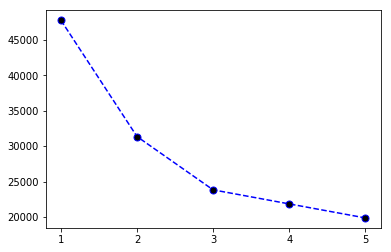

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()

x = list(range(1,6))
y = cost
xticks=list(range(1,6))
ticklabels = ['1','2','3','4','5']
plt.xticks(xticks, ticklabels)

ax.plot(x, y,color='blue', linestyle='dashed', marker='o',
     markerfacecolor='black', markersize=7);

# (Final) DataFrame with cluster_id

In [31]:
ids_train = pd.DataFrame(clusters, index = train.index, columns=['cluster_id'])

In [32]:
ids_test = pd.DataFrame(clusters_t, index = test.index, columns=['cluster_id'])

In [34]:
ids = pd.concat([ids_train, ids_test],axis=0,sort=False)
ids.reset_index(level=0, inplace=True)
ids.head()

,ticket_id,cluster_id
0,0x871325,1
1,0x8ba022,2
2,0x438957,2
3,0x399b90,1
4,0x779837,2


In [35]:
df_t = df.merge(ids,left_on = 'ticket_id', right_on = 'ticket_id')
df_t.head()

,ticket_id,location,burger,fries,salad,shake,weekday,time_of_day,cluster_id
0,0x7901ee,7,2.0,2.0,0.0,2.0,Wednesday,Dinner,1
1,0x12b47f,3,0.0,1.0,1.0,0.0,Wednesday,Afternoon,2
2,0x6d6979,6,2.0,2.0,0.0,0.0,Monday,Late-night,1
3,0x78dd1e,2,2.0,2.0,0.0,2.0,Sunday,Late-night,1
4,0x4df8ab,8,0.0,3.0,3.0,0.0,Thursday,Morning,2


In [36]:
df_t.cluster_id.value_counts() / len(df)

1    0.35395
2    0.34033
0    0.30572
Name: cluster_id, dtype: float64

## Looking at each segment

### segment 1 (mostly location 4,7,9)

In [37]:
condition = df_t['cluster_id'] == 0
segment1 = df_t.loc[condition,:]

In [38]:
segment1.ticket_id.nunique()

30572

In [39]:
segment1.head()

,ticket_id,location,burger,fries,salad,shake,weekday,time_of_day,cluster_id
6,0x755a0b,7,3.0,4.0,1.0,3.0,Sunday,Dinner,0
7,0x653685,6,4.0,4.0,0.0,1.0,Wednesday,Late-night,0
9,0x8ade21,7,2.0,3.0,1.0,2.0,Friday,Dinner,0
13,0x6cfd99,9,4.0,4.0,0.0,4.0,Sunday,Dinner,0
14,0x5886e5,9,4.0,4.0,0.0,4.0,Friday,Dinner,0


In [43]:
segment1[['burger','fries','salad','shake']].mean()

burger    3.889409
fries     4.065354
salad     0.175945
shake     3.403637
dtype: float64

In [44]:
segment1.time_of_day.value_counts()

Dinner        19298
Afternoon      8495
Late-night     2753
Morning          26
Name: time_of_day, dtype: int64

### segment 2 (mostly location 2,6)

In [45]:
condition = df_t['cluster_id'] == 1
segment2 = df_t.loc[condition,:]

In [46]:
segment2.ticket_id.nunique()

35395

In [47]:
segment2[['burger','fries','salad','shake']].mean()

burger    1.515129
fries     1.579997
salad     0.064868
shake     0.390196
dtype: float64

In [48]:
segment2.time_of_day.value_counts()

Late-night    31274
Dinner         3390
Morning         731
Name: time_of_day, dtype: int64

### segment 3 (mostly location 1,3,5,8)

In [49]:
condition = df_t['cluster_id'] == 2
segment3 = df_t.loc[condition,:]

In [50]:
segment3.ticket_id.nunique()

34033

In [51]:
segment3.time_of_day.value_counts()

Afternoon     25977
Morning        7371
Dinner          502
Late-night      183
Name: time_of_day, dtype: int64

### 3 clusters

In [54]:
all_encoded = pd.concat([train_with_id, train_with_id], axis=0)

In [56]:
all_encoded.groupby('cluster_id').mean()[['burger','fries','salad','shake','location_1','location_2','location_3',
                                           'location_4','location_5','location_6','location_7','location_8','location_9']]

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9
cluster_id,,,,,,,,,,,,,
0,3.888101,4.063882,0.175780,3.403520,0.029430,0.061300,0.031964,0.246984,0.031166,0.064633,0.246046,0.038395,0.250082
1,1.517137,1.581785,0.064647,0.388728,0.035482,0.353407,0.037573,0.051935,0.029005,0.348660,0.053343,0.037453,0.053142
2,0.388933,2.250157,1.861224,0.179385,0.188279,0.039980,0.186097,0.054495,0.191887,0.041029,0.055586,0.189579,0.053069
